# Import thư viện

In [2]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.exceptions import ConvergenceWarning
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

# Tải tệp dữ liệu

In [27]:
data = pd.read_csv('X_data.csv')

# Khám phá dữ liệu
### 1.Thông tin tổng quan về dữ liệu
- Kiểm tra kích thước dữ liệu, kiểu dữ liệu của từng cột.

In [29]:
print("Thông tin cơ bản của dữ liệu:")
print(data.info())

Thông tin cơ bản của dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    6000 non-null   int64  
 1   Age           6000 non-null   float64
 2   Systolic_BP   6000 non-null   float64
 3   Diastolic_BP  6000 non-null   float64
 4   Cholesterol   6000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 234.5 KB
None


### 2. Thống kê mô tả 
- Các thống kê cơ bản như giá trị min, max, trung bình, độ lệch chuẩn cho các biến số liên tục.

In [30]:
print("\nThống kê mô tả:")
print(data.describe())


Thống kê mô tả:
        Unnamed: 0          Age  Systolic_BP  Diastolic_BP  Cholesterol
count  6000.000000  6000.000000  6000.000000   6000.000000  6000.000000
mean   2999.500000    60.464121   100.694822     90.505547   100.628255
std    1732.195139     8.564392    10.669267      9.648200    10.433915
min       0.000000    35.164761    69.675429     62.807105    69.967453
25%    1499.750000    54.371941    93.267420     83.641788    93.202373
50%    2999.500000    59.831159   100.119926     89.912429   100.060637
75%    4499.250000    65.809652   107.439501     96.682405   107.250829
max    5999.000000   103.279497   151.699660    133.456382   148.233544


### 3. Kiểm tra giá trị thiếu
- Kiểm tra số lượng giá trị thiếu trong mỗi cột

In [6]:
print(data.isnull().sum())

Unnamed: 0      0
Age             0
Systolic_BP     0
Diastolic_BP    0
Cholesterol     0
dtype: int64


### 4. Phân phối dữ liệu

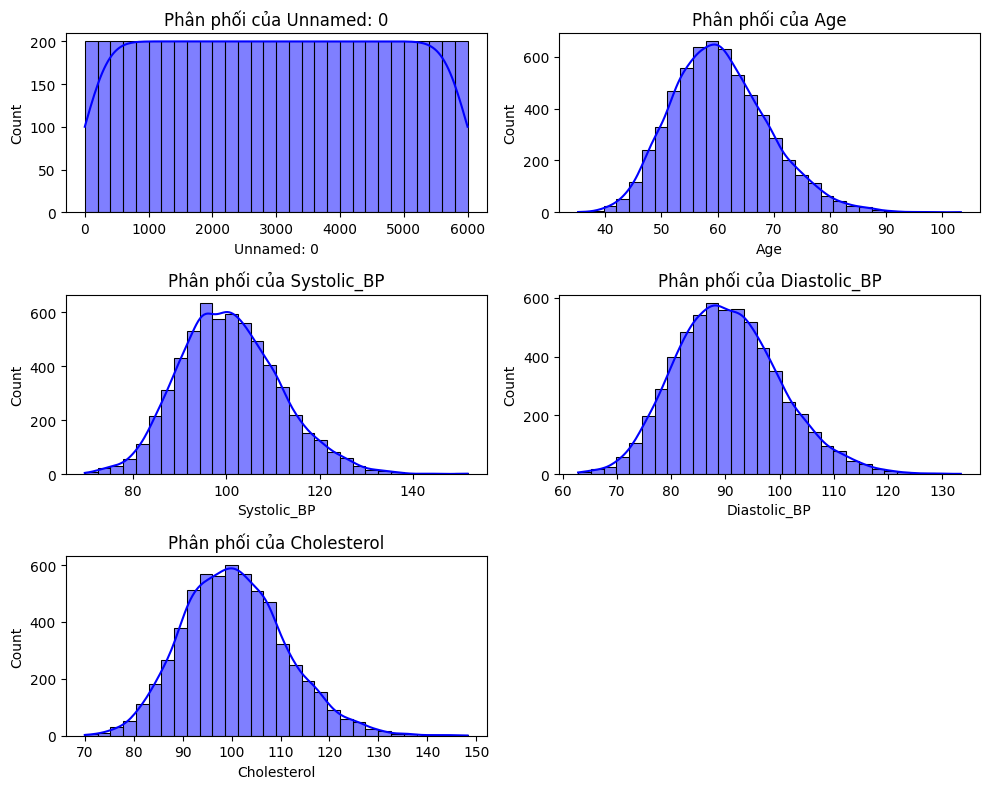

In [32]:
# Thiết lập biểu đồ
plt.figure(figsize=(10, 8))

# Lấy số lượng cột trong dữ liệu
num_cols = len(data.columns)

# Chỉnh sửa số lượng hàng và cột phù hợp với số cột dữ liệu
rows = (num_cols + 1) // 2  # Tính số hàng cần thiết

# Vẽ histogram cho từng cột
for i, col in enumerate(data.columns, 1):
    plt.subplot(rows, 2, i)
    sns.histplot(data[col], kde=True, bins=30, color='blue')
    plt.title(f"Phân phối của {col}")
plt.tight_layout()
plt.show()

### 3. Biểu đồ Boxplot kiểm tra ngoại lệ

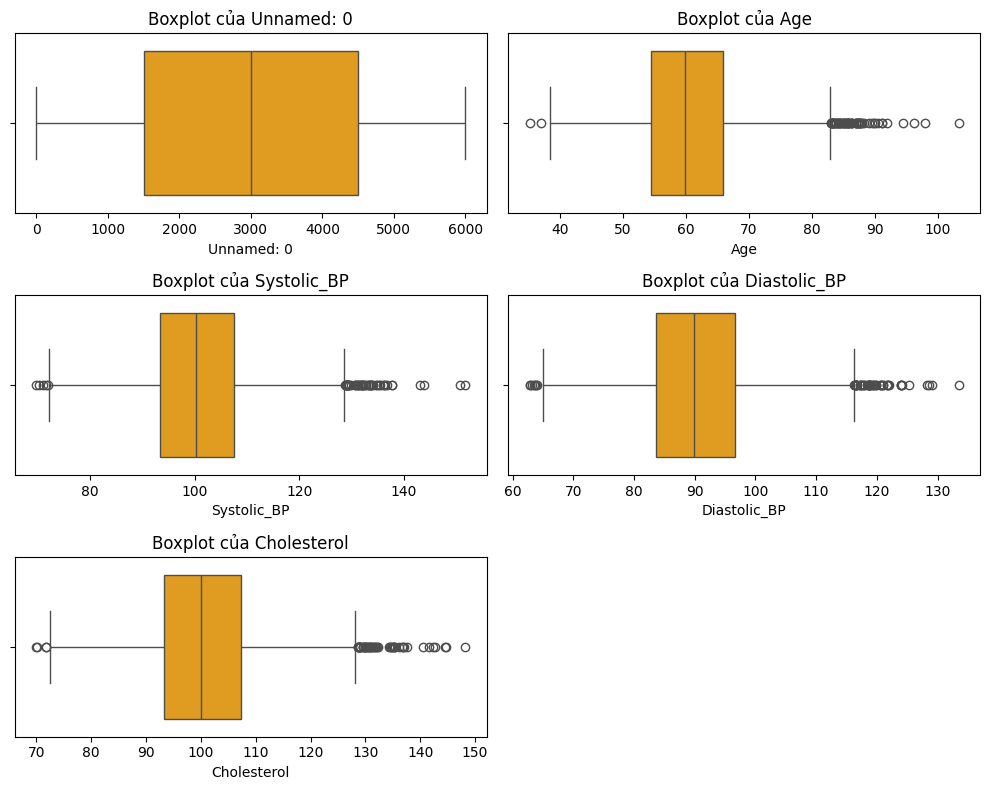

In [35]:
# Thiết lập biểu đồ
plt.figure(figsize=(10, 8))

# Lấy số lượng cột trong dữ liệu
num_cols = len(data.columns)

rows = (num_cols + 1) // 2  # Tính số hàng cần thiết

# Vẽ boxplot cho từng cột
for i, col in enumerate(data.columns, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f"Boxplot của {col}")
plt.tight_layout()
33plt.show()

### 4. Ma trận tương quan

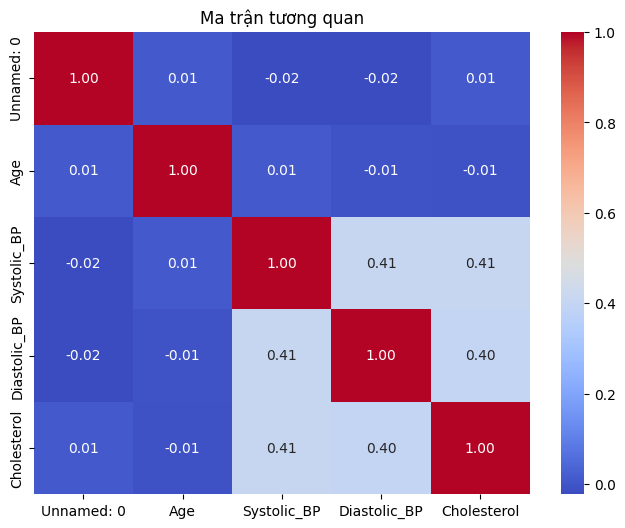

In [36]:
# Vẽ ma trận tương quan
plt.figure(figsize=(8, 6))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan")
plt.show()

### 5. Kiểm tra ngoại lệ (IQR Method)

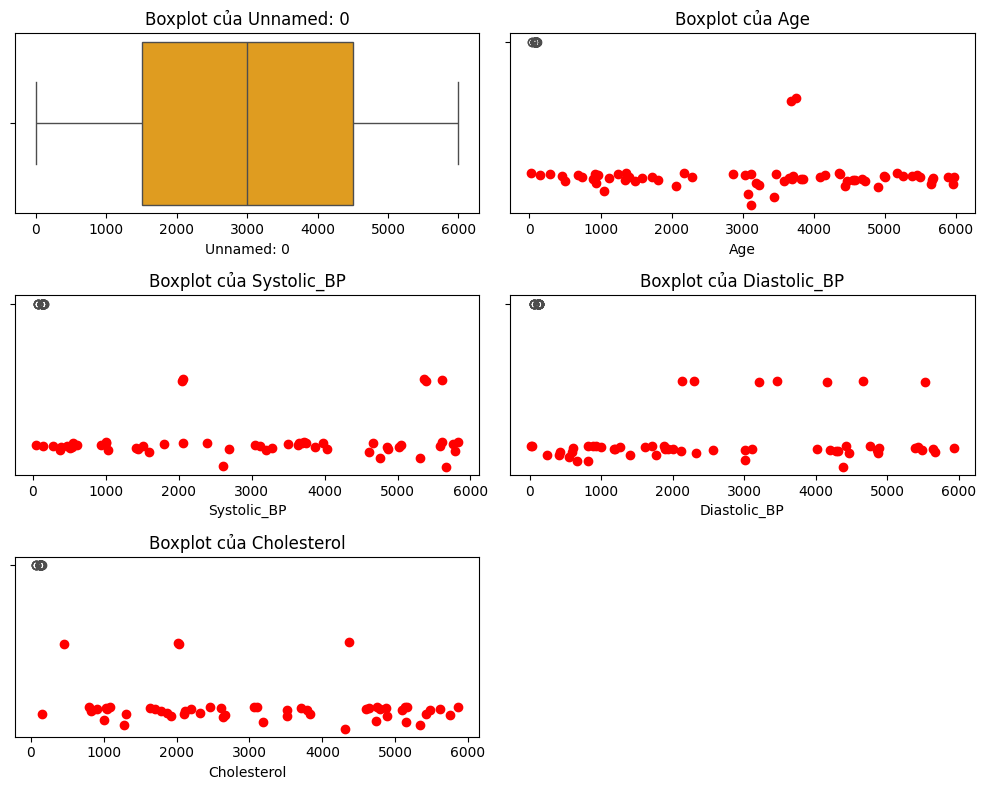

In [40]:
# Thiết lập biểu đồ
plt.figure(figsize=(10, 8))

# Lấy số lượng cột trong dữ liệu
num_cols = len(data.columns)

# Chỉnh sửa số lượng hàng và cột phù hợp với số cột dữ liệu
rows = (num_cols + 1) // 2  # Tính số hàng cần thiết

# Vẽ boxplot cho từng cột dữ liệu
for i, col in enumerate(data.columns, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=data[col], color='orange')

    # Tính toán các ngoại lệ dựa trên phương pháp IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Vẽ các ngoại lệ
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    plt.scatter(outliers.index, outliers[col], color='red', label='Outliers', zorder=5)

    plt.title(f"Boxplot của {col}")

plt.tight_layout()
plt.show()

### 6. Trực quan hóa mối quan hệ giữa các biến

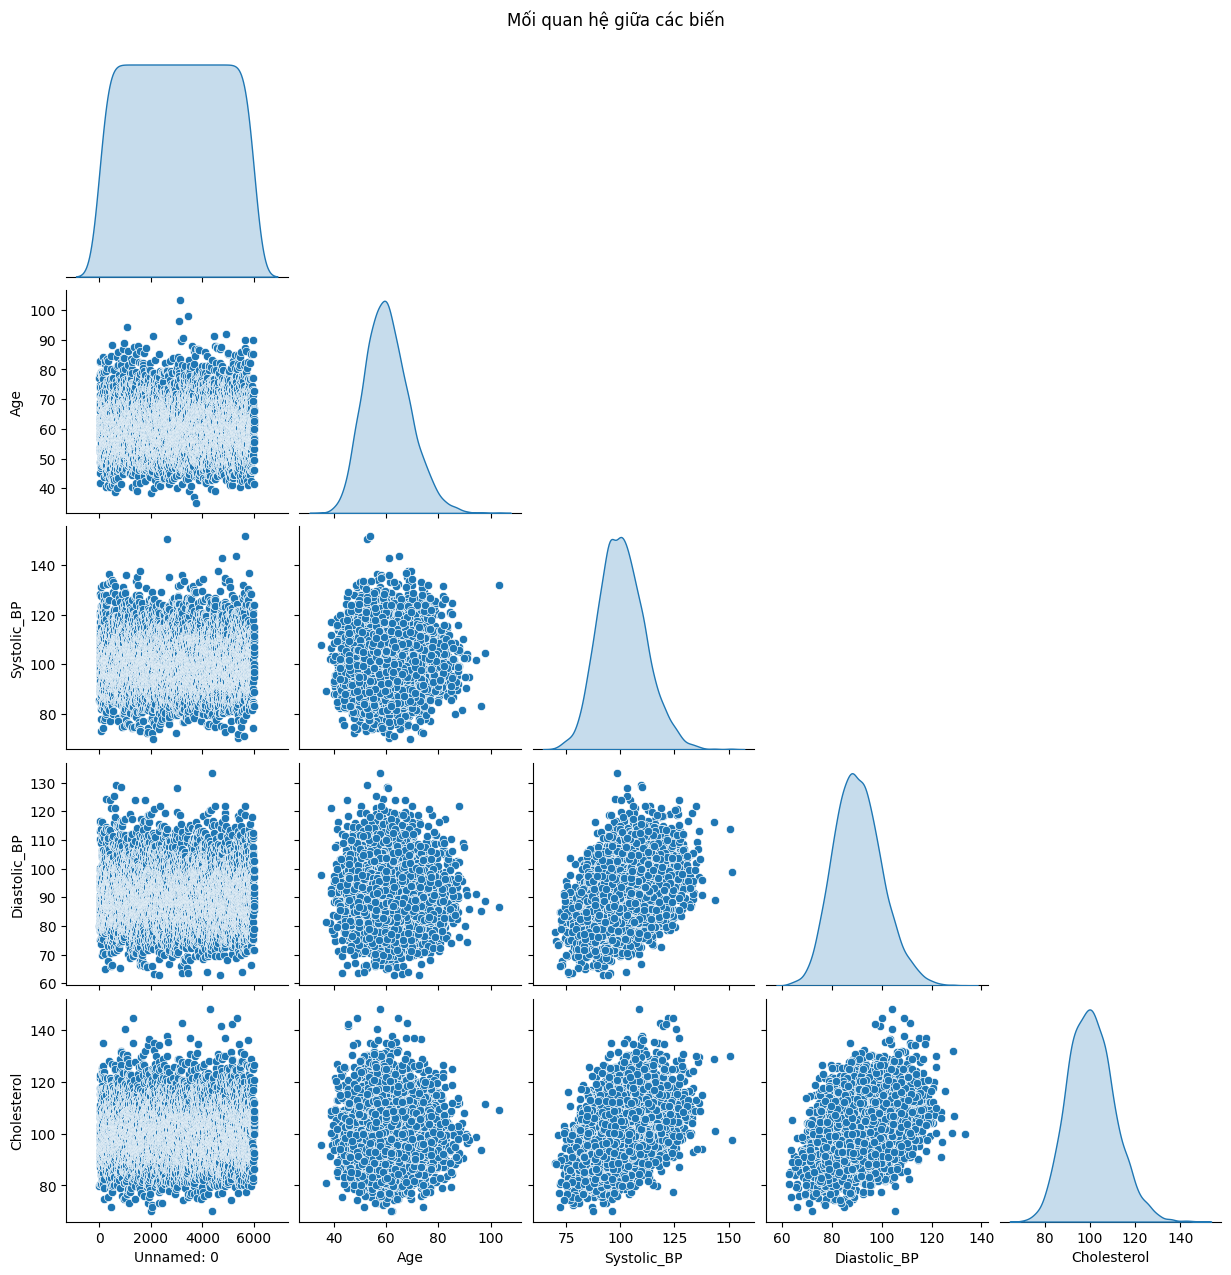

In [42]:
# Vẽ cặp đôi biến với seaborn pairplot
sns.pairplot(data, diag_kind='kde', corner=True)
plt.suptitle("Mối quan hệ giữa các biến", y=1.02)
plt.show()

### 7. Phân tích tương quan giữa các biến cụ thể

              Unnamed: 0       Age  Systolic_BP  Diastolic_BP  Cholesterol
Unnamed: 0      1.000000  0.010941    -0.023931     -0.018792     0.004054
Age             0.010941  1.000000     0.000232     -0.009103    -0.002499
Systolic_BP    -0.023931  0.000232     1.000000      0.392569     0.397709
Diastolic_BP   -0.018792 -0.009103     0.392569      1.000000     0.378355
Cholesterol     0.004054 -0.002499     0.397709      0.378355     1.000000


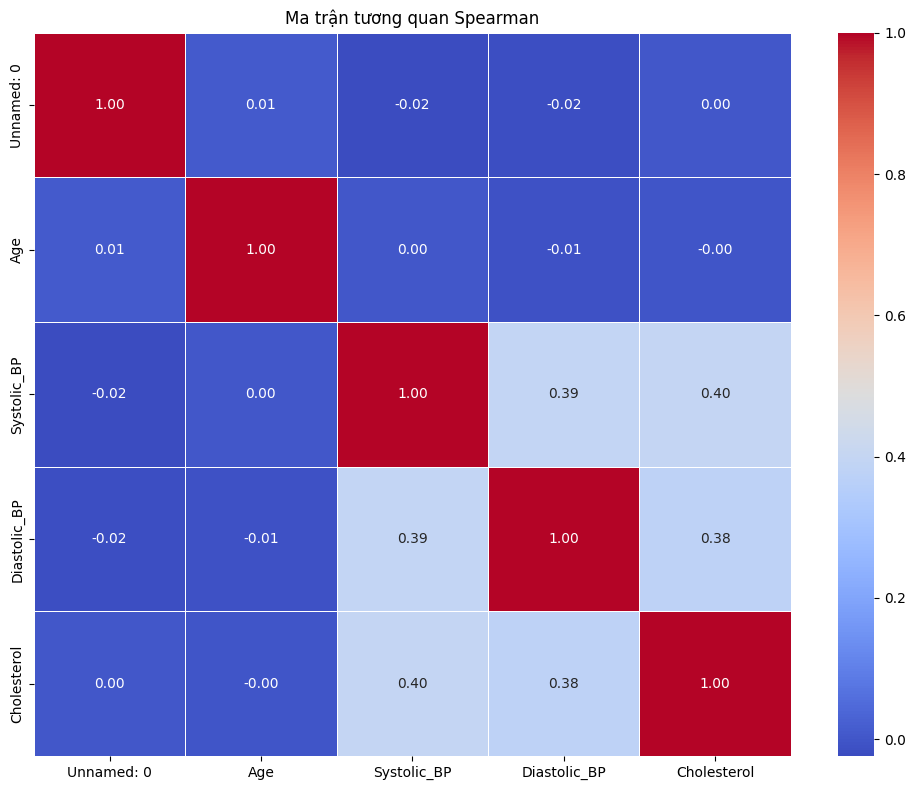

In [46]:
# Tính ma trận tương quan Spearman
spearman_corr_matrix = data.corr(method='spearman')

# In ra ma trận tương quan Spearman
print(spearman_corr_matrix)

# Vẽ heatmap cho ma trận tương quan Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Ma trận tương quan Spearman")
plt.tight_layout()
plt.show()

### Tiền xử lý dữ liệu

In [4]:
# Loại bỏ các giá không cần thiết
X = data.iloc[:, 1:].values

# 1. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Model

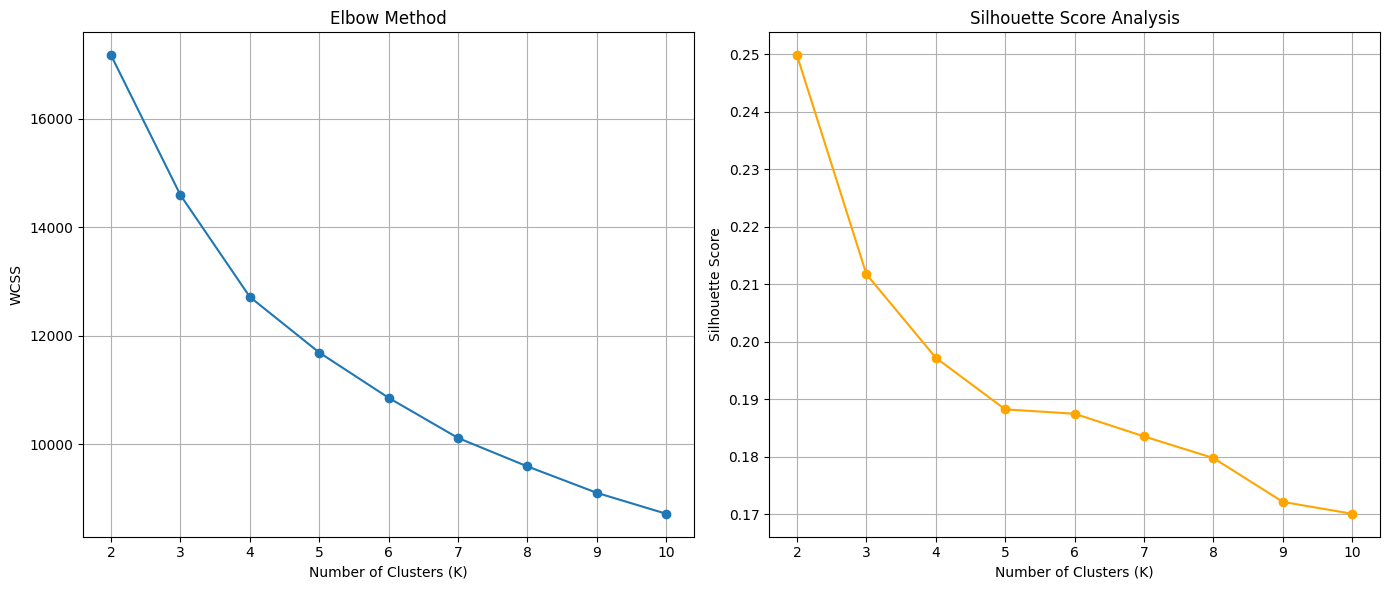

Silhouette Score: 0.250
Calinski-Harabasz Index: 2384.348
Davies-Bouldin Index: 1.478


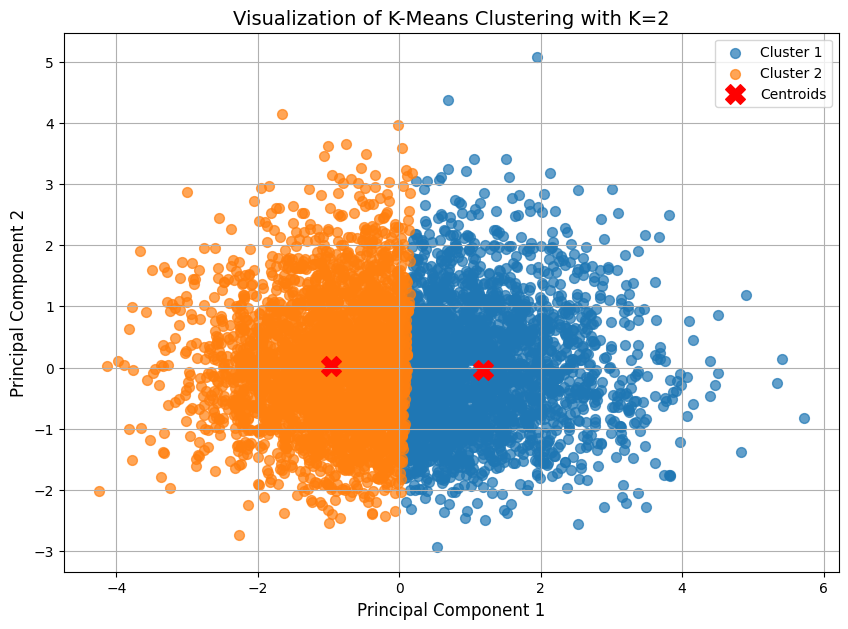

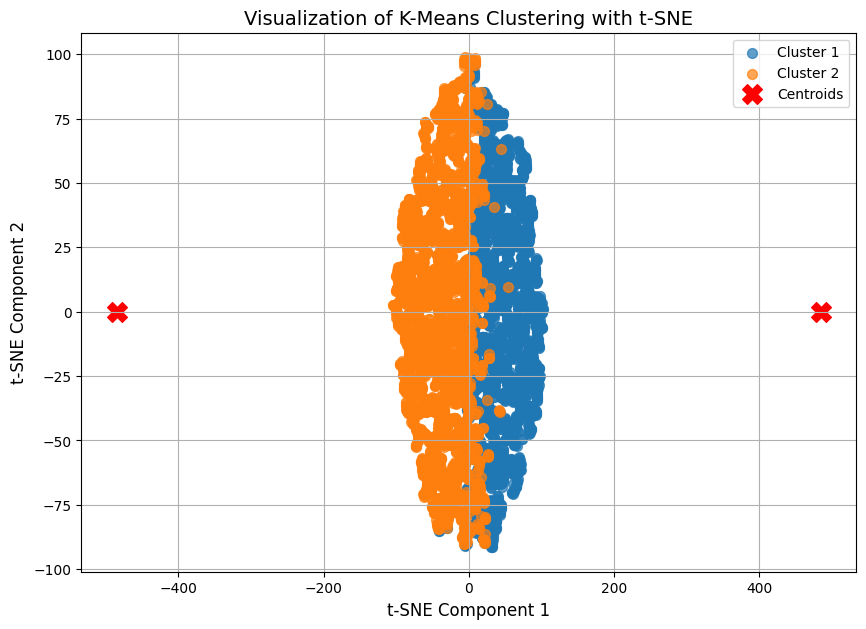

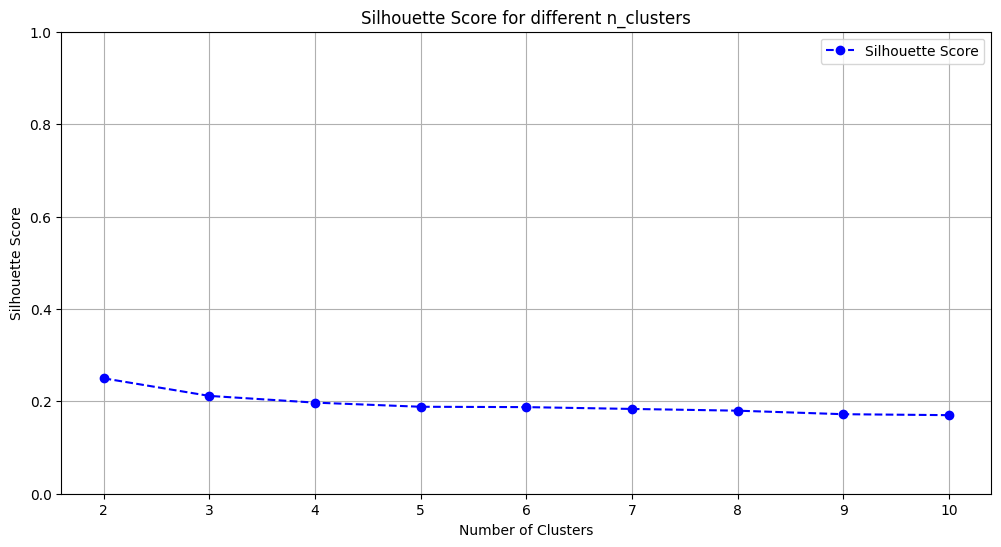

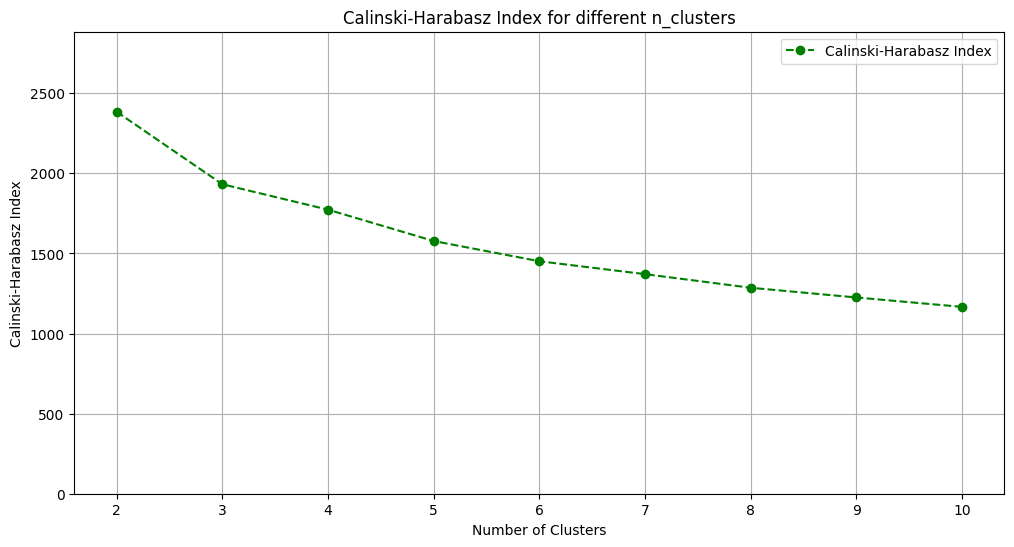

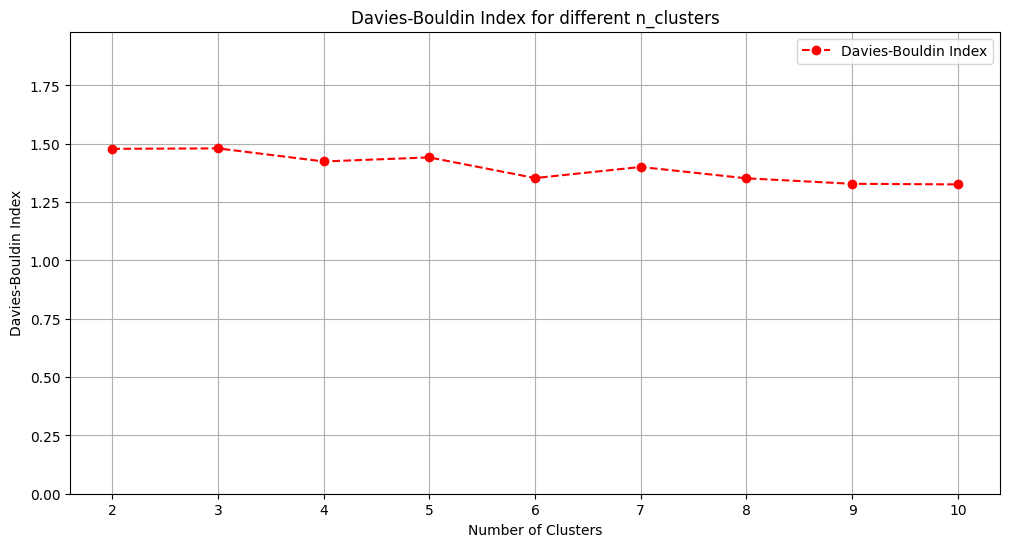

In [12]:
# Initialize variables for Elbow Method and Silhouette Score
wcss = []
silhouette_scores = []
K_range = range(2, 11)  # Check for K from 2 to 10

# Compute WCSS and Silhouette Scores for each K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Append WCSS for Elbow Method

    # Compute Silhouette Score
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid()

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score Analysis')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid()

plt.tight_layout()
plt.show()

# Fit K-Means with K = 3
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10, max_iter=300)
kmeans.fit(X_scaled)

# Lấy nhãn cụm
labels = kmeans.labels_

# Tính các chỉ số đánh giá
silhouette_avg = silhouette_score(X_scaled, labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)

# In các chỉ số
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

# Giảm số chiều với PCA để vẽ biểu đồ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Vẽ scatter plot cho các điểm dữ liệu
plt.figure(figsize=(10, 7))
for cluster in range(K):  # Số cụm K = 2
    plt.scatter(X_pca[labels == cluster, 0], X_pca[labels == cluster, 1], 
                label=f'Cluster {cluster + 1}', s=50, alpha=0.7)

# Vẽ tâm cụm
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='red', marker='X', s=200, label='Centroids')

# Tùy chỉnh biểu đồ
plt.title(f'Visualization of K-Means Clustering with K={K}', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Trực quan hóa bằng t-SNE
tsne = TSNE(n_components=2, perplexity=min(5, kmeans.cluster_centers_.shape[0] - 1), random_state=42)
centroids_tsne = tsne.fit_transform(kmeans.cluster_centers_)

# Vẽ biểu đồ phân cụm với t-SNE
plt.figure(figsize=(10, 7))
for cluster in range(K):  # Số cụm K = 3
    plt.scatter(X_tsne[labels == cluster, 0], X_tsne[labels == cluster, 1], 
                label=f'Cluster {cluster + 1}', s=50, alpha=0.7)

# Vẽ tâm cụm trong không gian t-SNE
# Lấy các tâm cụm trong không gian ban đầu và áp dụng t-SNE lên các tâm này
centroids_tsne = tsne.fit_transform(kmeans.cluster_centers_)  # Áp dụng fit_transform cho các tâm cụm
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], 
            c='red', marker='X', s=200, label='Centroids')

# Tùy chỉnh biểu đồ t-SNE
plt.title('Visualization of K-Means Clustering with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Initialize lists to store scores
silhouette_scores = []  # For Silhouette Score
calinski_scores = []    # For Calinski-Harabasz Index
davies_bouldin_scores = []  # For Davies-Bouldin Index

# Define range for number of clusters
range_n_clusters = range(2, 11)

# Compute scores for each K
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    # Append Silhouette Score
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    # Append Calinski-Harabasz Index
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    # Append Davies-Bouldin Index
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# 1. Plot Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='b', label='Silhouette Score', linestyle='--')
plt.title('Silhouette Score for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.ylim(0.0, 1.0)
plt.show()

# 2. Plot Calinski-Harabasz Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, calinski_scores, marker='o', color='g', label='Calinski-Harabasz Index', linestyle='--')
    plt.title('Calinski-Harabasz Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.ylim(0.0, max(calinski_scores) + 500)  # Dynamic y-axis limit
plt.show()

# 3. Plot Davies-Bouldin Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', color='r', label='Davies-Bouldin Index', linestyle='--')
plt.title('Davies-Bouldin Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.ylim(0.0, max(davies_bouldin_scores) + 0.5)  # Dynamic y-axis limit
plt.show()


# DBSCAN(Density-Based Spatial Clustering of Applications with Noise)

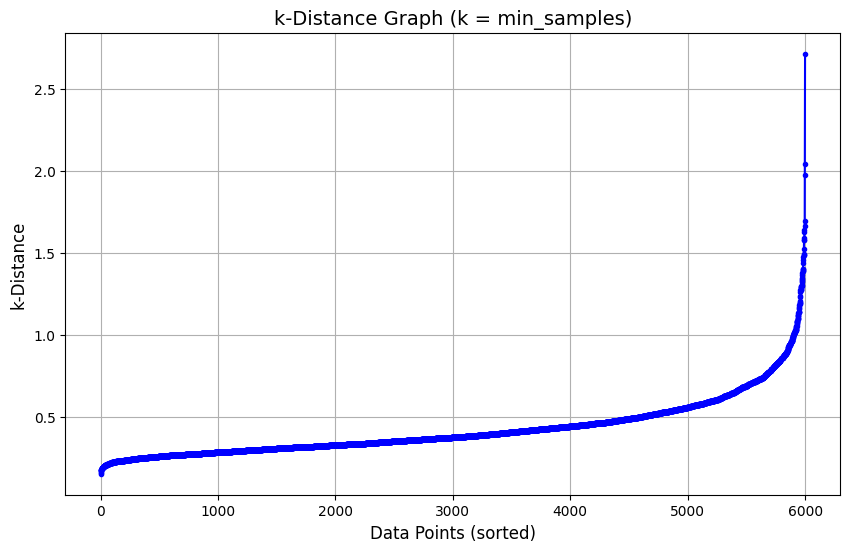

Silhouette Score (optimized): -0.066
Calinski-Harabasz Index (optimized): 65.263
Davies-Bouldin Index (optimized): 3.436


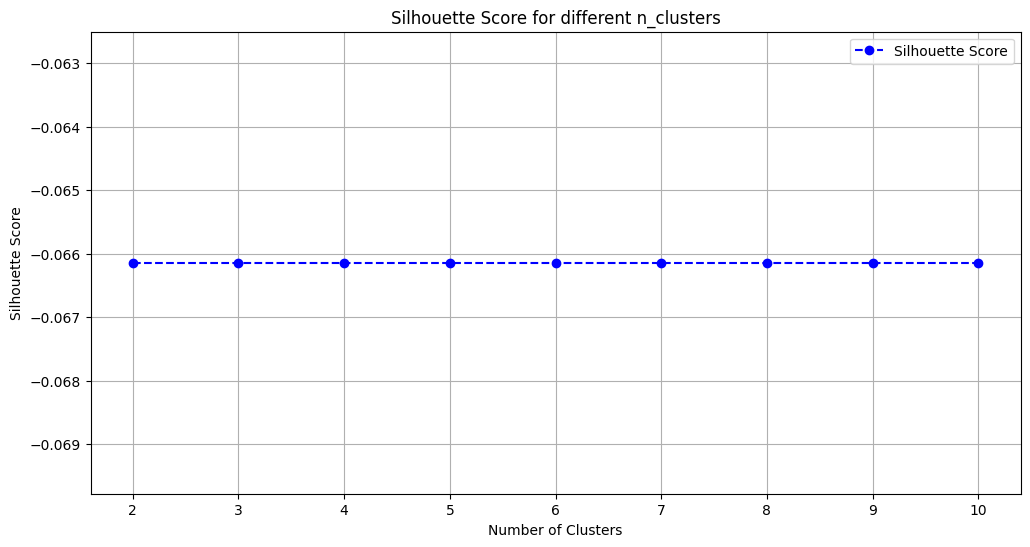

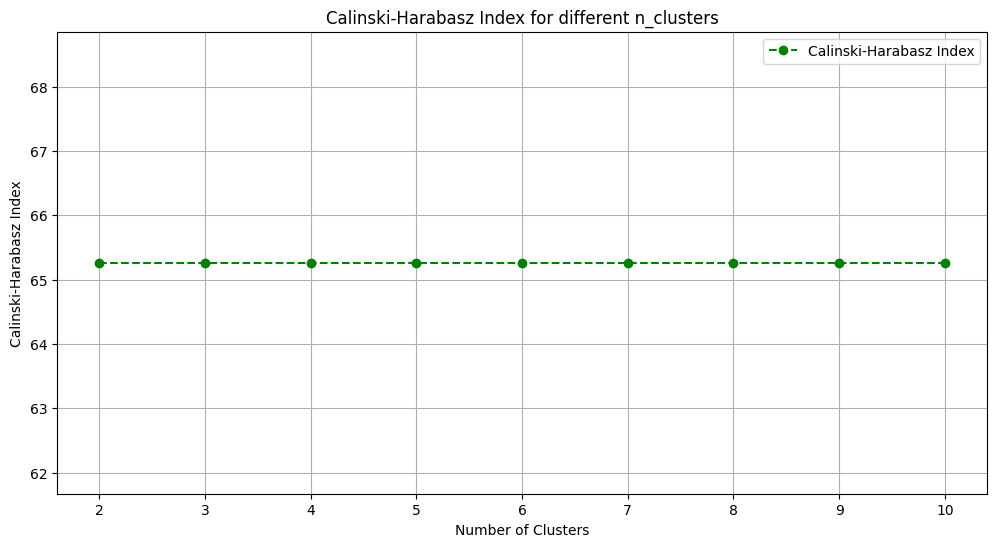

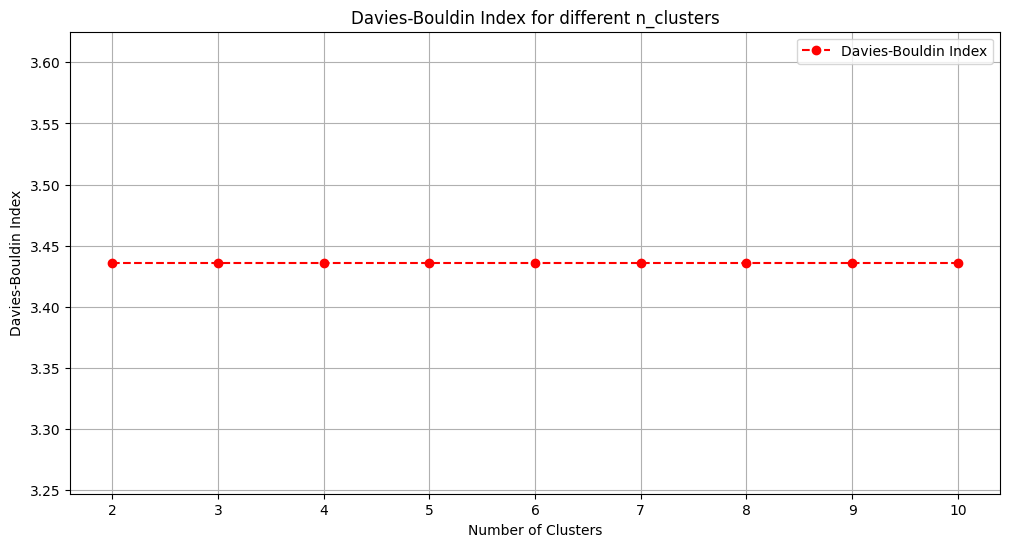

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Calinski-Harabasz Index: 2
Optimal number of clusters based on Davies-Bouldin Index: 2


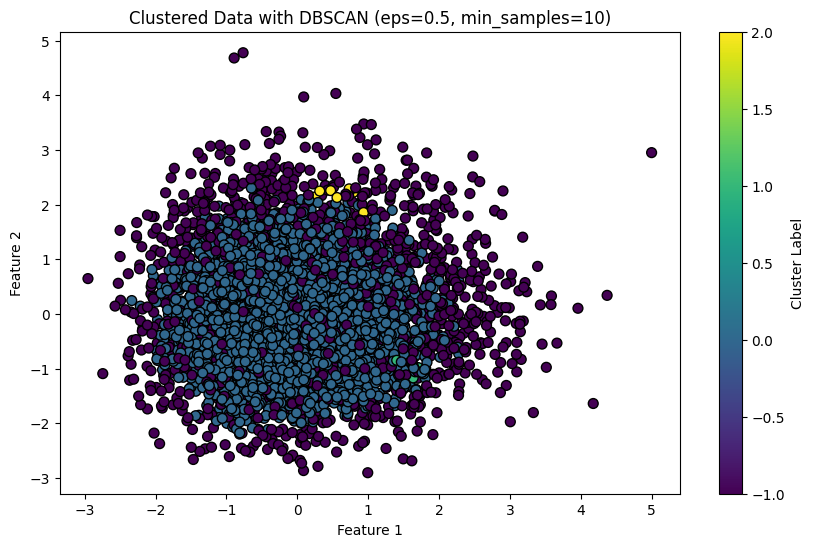

In [48]:
# 2. Tính toán k-Distance Graph
min_samples = 5  # Giá trị mặc định
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sắp xếp khoảng cách
distances = np.sort(distances[:, -1])

# Vẽ k-Distance Graph
plt.figure(figsize=(10, 6))
plt.plot(distances, color='blue', marker='o', markersize=3, linestyle='-')
plt.title('k-Distance Graph (k = min_samples)', fontsize=14)
plt.xlabel('Data Points (sorted)', fontsize=12)
plt.ylabel('k-Distance', fontsize=12)
plt.grid()
plt.show()

# 3. Chọn eps từ k-Distance Graph (Lựa chọn dựa trên điểm gãy trong đồ thị)
optimal_eps = 0.5  # Thay đổi giá trị dựa trên điểm gãy
optimal_min_samples = 10  # Giá trị min_samples

# 4. Tối ưu hóa DBSCAN
dbscan_optimized = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_optimized.fit(X_scaled)

# Lấy nhãn cụm
labels_opt = dbscan_optimized.labels_

# Đếm số cụm và điểm nhiễu
n_clusters_opt = len(set(labels_opt)) - (1 if -1 in labels_opt else 0)
n_noise_opt = list(labels_opt).count(-1)

# Đánh giá mô hình
silhouette_opt = None
calinski_harabasz_opt = None
davies_bouldin_opt = None

if n_clusters_opt > 1:
    silhouette_opt = silhouette_score(X_scaled, labels_opt)
    calinski_harabasz_opt = calinski_harabasz_score(X_scaled, labels_opt)
    davies_bouldin_opt = davies_bouldin_score(X_scaled, labels_opt)

    print(f"Silhouette Score (optimized): {silhouette_opt:.3f}")
    print(f"Calinski-Harabasz Index (optimized): {calinski_harabasz_opt:.3f}")
    print(f"Davies-Bouldin Index (optimized): {davies_bouldin_opt:.3f}")
else:
    print("Not enough clusters to calculate evaluation metrics.")

# 5. Vẽ các biểu đồ cho từng chỉ số đánh giá
range_n_clusters = list(range(2, 11))

# Chỉ số đánh giá cho DBSCAN
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

# Đánh giá cho mỗi giá trị n_clusters từ 2 đến 10
for n_clusters in range_n_clusters:
    dbscan_optimized = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    dbscan_optimized.fit(X_scaled)

    labels = dbscan_optimized.labels_
    
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    else:
        silhouette_scores.append(-1)
        calinski_scores.append(0)
        davies_bouldin_scores.append(np.inf)

# 1. Vẽ biểu đồ Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='b', label='Silhouette Score', linestyle='--')
plt.title('Silhouette Score for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# 2. Vẽ biểu đồ Calinski-Harabasz Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, calinski_scores, marker='o', color='g', label='Calinski-Harabasz Index', linestyle='--')
plt.title('Calinski-Harabasz Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# 3. Vẽ biểu đồ Davies-Bouldin Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', color='r', label='Davies-Bouldin Index', linestyle='--')
plt.title('Davies-Bouldin Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# 6. Chọn số cụm tối ưu từ các chỉ số đánh giá
optimal_clusters_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
optimal_clusters_calinski = range_n_clusters[np.argmax(calinski_scores)]
optimal_clusters_davies = range_n_clusters[np.argmin(davies_bouldin_scores)]

# In kết quả
print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters_silhouette}")
print(f"Optimal number of clusters based on Calinski-Harabasz Index: {optimal_clusters_calinski}")
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_clusters_davies}")

# 7. Vẽ kết quả phân cụm với số cụm tối ưu
# Giả sử bạn chọn từ Silhouette Score
optimal_n_clusters = optimal_clusters_silhouette

# Tiến hành phân cụm lại với số cụm tối ưu
dbscan_optimized_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_optimized_final.fit(X_scaled)

# Lấy nhãn cụm của từng điểm
labels_final = dbscan_optimized_final.labels_

# Vẽ kết quả phân cụm
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_final, cmap='viridis', s=50, edgecolor='k')
plt.title(f'Clustered Data with DBSCAN (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# AgglomerativeClustering

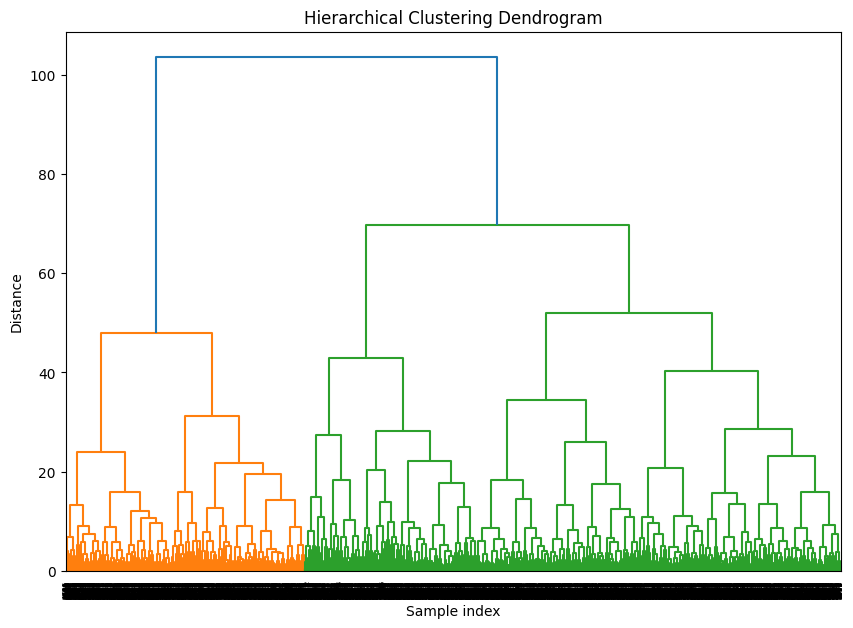

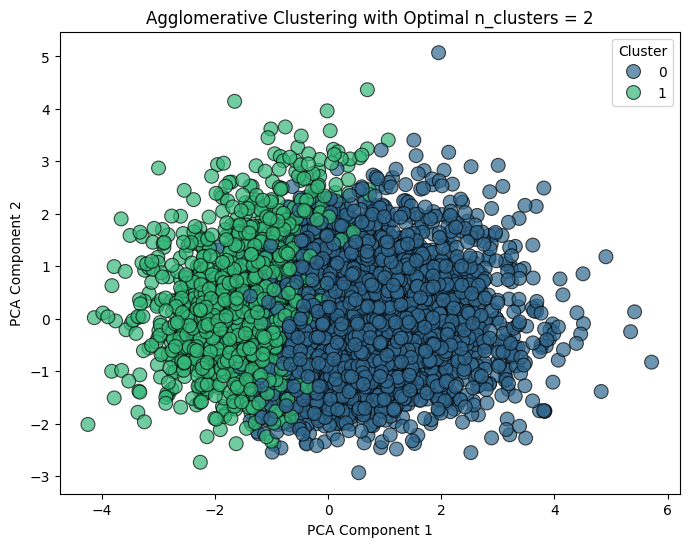

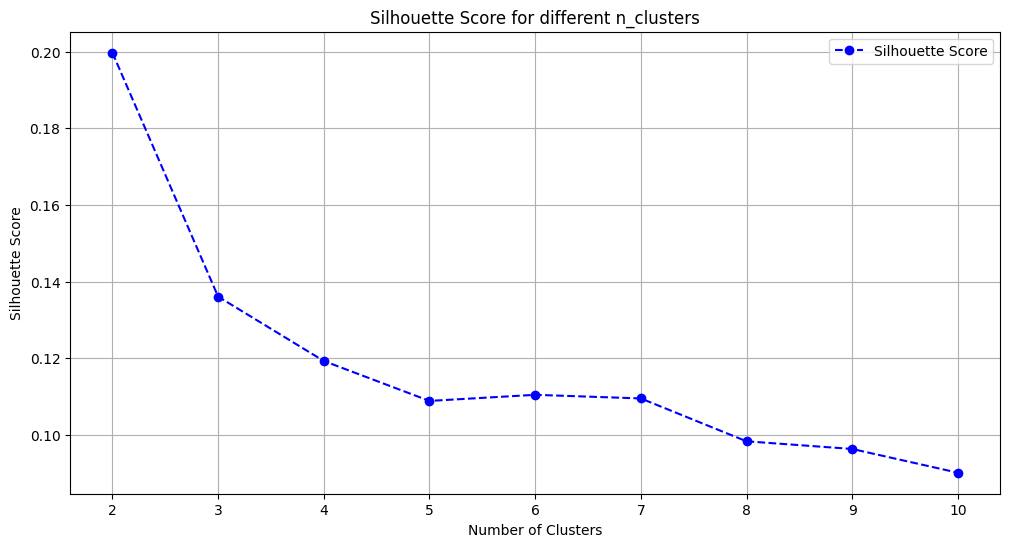

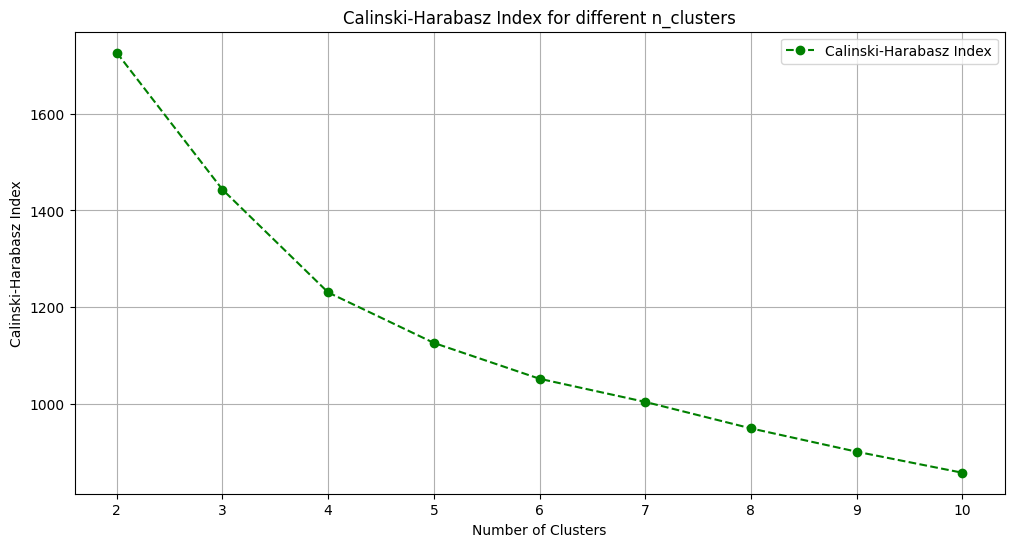

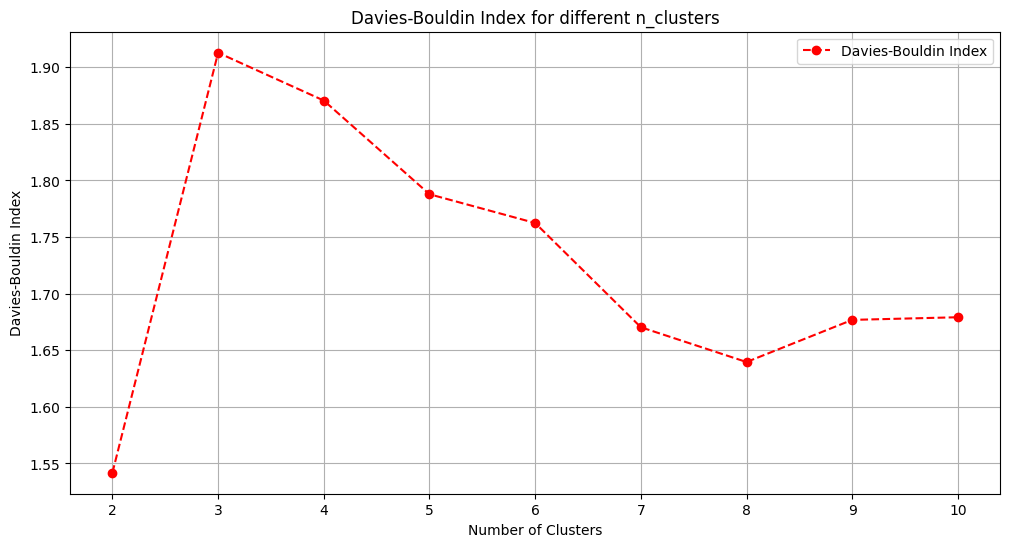

Optimal number of clusters: 2
Silhouette Score (Optimal): 0.19974729621333312
Calinski-Harabasz Index (Optimal): 1725.575590623273
Davies-Bouldin Index (Optimal): 1.5418411406769292


In [50]:
# 2. Tính dendrogram
linked = linkage(X_scaled, method='ward')

# 3. Vẽ dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 4. Duyệt qua số cụm từ 2 đến 10 và tính các chỉ số đánh giá
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_clustering.fit(X_scaled)

    # Tính các chỉ số đánh giá
    silhouette_scores.append(silhouette_score(X_scaled, agg_clustering.labels_))
    calinski_scores.append(calinski_harabasz_score(X_scaled, agg_clustering.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, agg_clustering.labels_))

# 5. Tìm số cụm tối ưu dựa trên Silhouette Score
best_silhouette_score = max(silhouette_scores)
optimal_n_clusters = range_n_clusters[silhouette_scores.index(best_silhouette_score)]

# 6. Xây dựng mô hình Agglomerative Clustering với số cụm tối ưu
agg_clustering_optimal = AgglomerativeClustering(n_clusters=optimal_n_clusters)
agg_clustering_optimal.fit(X_scaled)

# 7. Giảm chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 8. Vẽ biểu đồ phân cụm với số cụm tối ưu
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_clustering_optimal.labels_, palette='viridis', s=100, edgecolor='k', alpha=0.7)
plt.title(f'Agglomerative Clustering with Optimal n_clusters = {optimal_n_clusters}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 9. Vẽ các biểu đồ đánh giá
# Biểu đồ Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='b', label='Silhouette Score', linestyle='--')
plt.title('Silhouette Score for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# Biểu đồ Calinski-Harabasz Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, calinski_scores, marker='o', color='g', label='Calinski-Harabasz Index', linestyle='--')
plt.title('Calinski-Harabasz Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# Biểu đồ Davies-Bouldin Index
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', color='r', label='Davies-Bouldin Index', linestyle='--')
plt.title('Davies-Bouldin Index for different n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# In các chỉ số đánh giá cho số cụm tối ưu
print(f"Optimal number of clusters: {optimal_n_clusters}")
print(f"Silhouette Score (Optimal): {best_silhouette_score}")
print(f"Calinski-Harabasz Index (Optimal): {calinski_scores[silhouette_scores.index(best_silhouette_score)]}")
print(f"Davies-Bouldin Index (Optimal): {davies_bouldin_scores[silhouette_scores.index(best_silhouette_score)]}")

# Gaussian Mixture Model

In [51]:
# 2. Apply Kernel PCA with multiple gamma values
def apply_kernel_pca(X, gammas):
    results = {}
    for gamma in gammas:
        kernel_pca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
        X_kpca = kernel_pca.fit_transform(X)
        results[gamma] = X_kpca
    return results

gamma_values = [0.01, 0.1, 1, 10]
kpca_results = apply_kernel_pca(X_scaled, gamma_values)

In [52]:
# 3. Automatic selection of optimal clusters using BIC/AIC
def find_best_gmm(X, covariance_types, max_clusters):
    best_gmm = None
    best_bic = np.inf
    best_params = {}

    for cov_type in covariance_types:
        for n_clusters in range(2, max_clusters + 1):
            gmm = GaussianMixture(
                n_components=n_clusters, 
                covariance_type=cov_type, 
                max_iter=2000, 
                tol=1e-4, 
                reg_covar=1e-6,
                random_state=42
            )
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    gmm.fit(X)
                bic = gmm.bic(X)
                if bic < best_bic:
                    best_bic = bic
                    best_gmm = gmm
                    best_params = {'n_components': n_clusters, 'covariance_type': cov_type}
            except ValueError as e:
                print(f"Error fitting GMM: {e}")
                continue
    return best_gmm, best_params

# Select gamma with best silhouette score
def evaluate_kpca_results(kpca_results):
    best_score = -1
    best_gamma = None
    best_X_kpca = None

    for gamma, X_kpca in kpca_results.items():
        gmm, params = find_best_gmm(X_kpca, ['full', 'tied', 'diag', 'spherical'], 5)
        if gmm is not None:
            labels = gmm.predict(X_kpca)
            score = silhouette_score(X_kpca, labels)
            if score > best_score:
                best_score = score
                best_gamma = gamma
                best_X_kpca = X_kpca

    return best_gamma, best_X_kpca

best_gamma, X_kpca = evaluate_kpca_results(kpca_results)

In [53]:
# 4. Outlier removal with Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_kpca)
X_filtered = X_kpca[outlier_labels == 1]

# Refit GMM on filtered data
gmm, best_params = find_best_gmm(X_filtered, ['full', 'tied', 'diag', 'spherical'], 5)
best_labels = gmm.predict(X_filtered)

In [54]:
# 5. Visualize with t-SNE (for filtered data)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

In [55]:
# 6. Hyperparameter tuning with GridSearchCV (Optional)
param_grid = {
    'n_components': range(2, 6),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-4]
}

best_gmm = None
best_params = None
best_score = -1

# Perform hyperparameter tuning to find the best model
for params in ParameterGrid(param_grid):
    gmm = GaussianMixture(**params, random_state=42)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            gmm.fit(X_filtered)
        labels = gmm.predict(X_filtered)
        score = silhouette_score(X_filtered, labels)
        if score > best_score:
            best_score = score
            best_gmm = gmm
            best_params = params
    except ValueError as e:
        print(f"Error in hyperparameter tuning: {e}")
        continue

# Evaluate additional metrics
best_labels = best_gmm.predict(X_filtered)
silhouette = silhouette_score(X_filtered, best_labels)
calinski_harabasz = calinski_harabasz_score(X_filtered, best_labels)
davies_bouldin = davies_bouldin_score(X_filtered, best_labels)

print("Best Parameters:", best_params)
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Best Parameters: {'covariance_type': 'tied', 'n_components': 2, 'reg_covar': 0.0001, 'tol': 0.001}
Silhouette Score: 0.8243968380135402
Calinski-Harabasz Index: 3489.685857839577
Davies-Bouldin Index: 0.6815563963259039


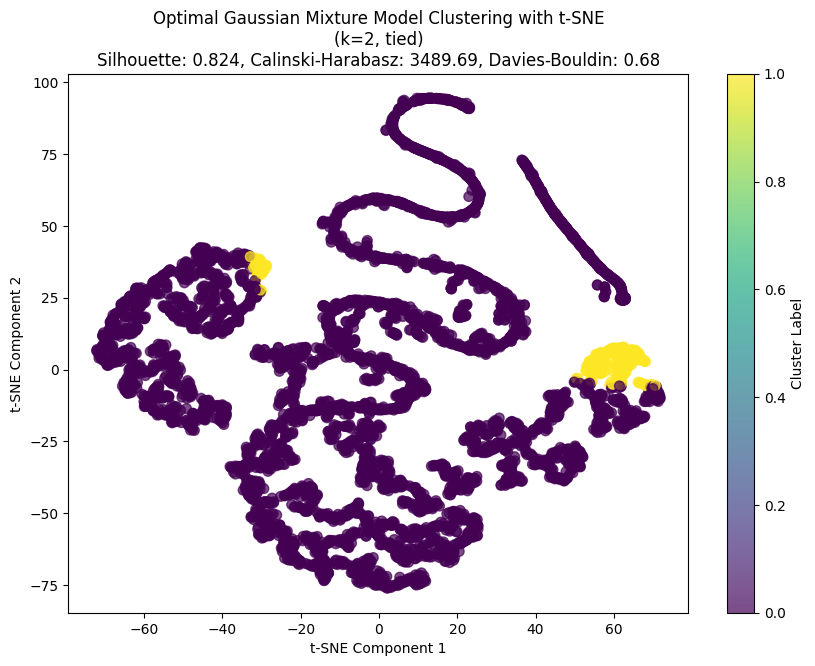

In [56]:
# 7. Visualize clustering result with t-SNE
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(
    f"Optimal Gaussian Mixture Model Clustering with t-SNE\n"
    f"(k={best_params['n_components']}, {best_params['covariance_type']})\n"
    f"Silhouette: {silhouette:.3f}, Calinski-Harabasz: {calinski_harabasz:.2f}, Davies-Bouldin: {davies_bouldin:.2f}"
)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

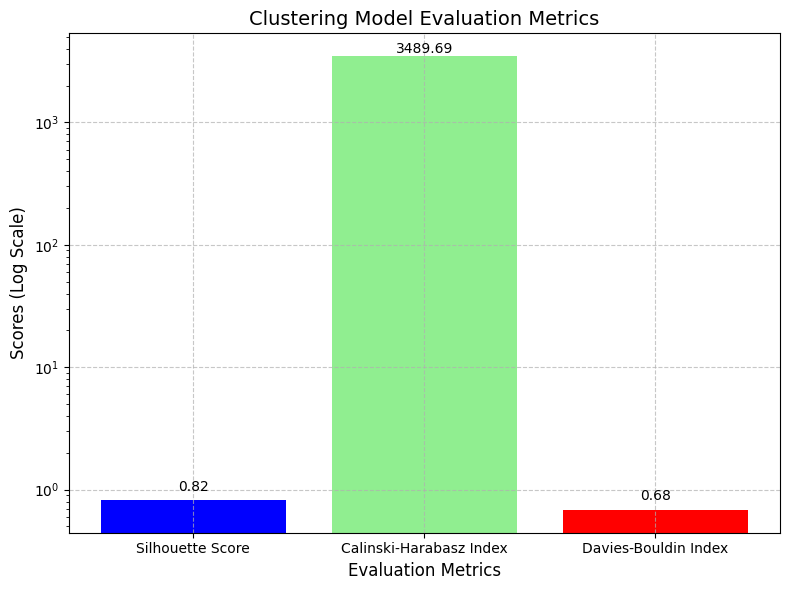

In [57]:
# 8. Visualize metrics
metrics = {
    "Silhouette Score": silhouette,
    "Calinski-Harabasz Index": calinski_harabasz,
    "Davies-Bouldin Index": davies_bouldin
}

fig, ax = plt.subplots(figsize=(8, 6))

labels = list(metrics.keys())
values = list(metrics.values())

ax.bar(labels, values, color=['blue', 'lightgreen', 'red'])
ax.set_yscale('log')  # Set log scale for better visualization

ax.set_title("Clustering Model Evaluation Metrics", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("Evaluation Metrics", fontsize=12)
ax.set_ylabel("Scores (Log Scale)", fontsize=12)

for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

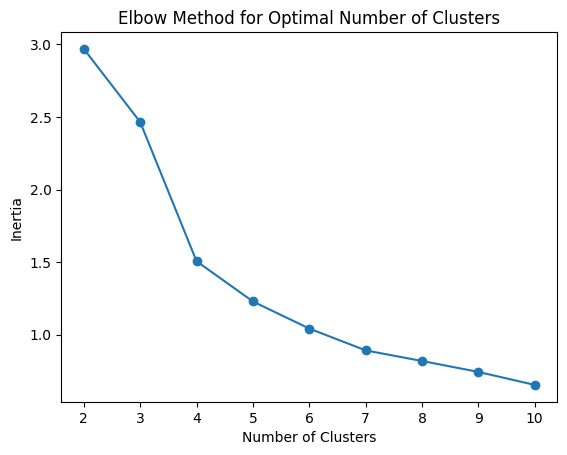

In [58]:
# 9. Elbow Method for Optimal Clusters
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_filtered)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

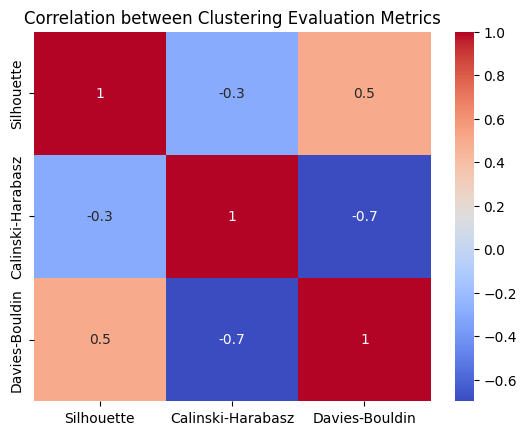

In [59]:
# 10. Heatmap for Correlation of Metrics
metrics_matrix = np.array([
    [1, -0.3, 0.5],
    [-0.3, 1, -0.7],
    [0.5, -0.7, 1]
])

sns.heatmap(metrics_matrix, annot=True, cmap='coolwarm', xticklabels=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'], yticklabels=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
plt.title("Correlation between Clustering Evaluation Metrics")
plt.show()

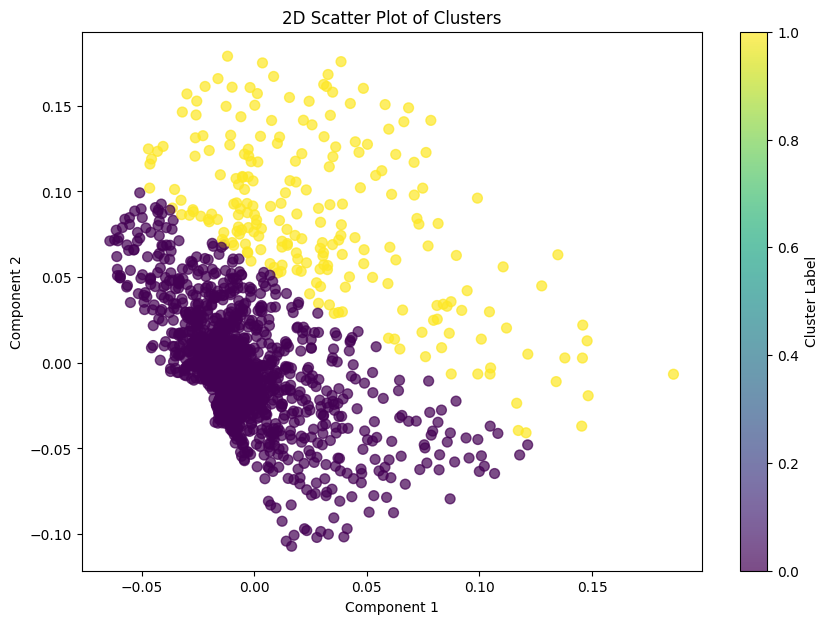

In [60]:
# 11. 2D Visualization of Clusters (Sửa lại vẽ 2D thay vì 3D)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Đánh giá tổng quan các mô hình 

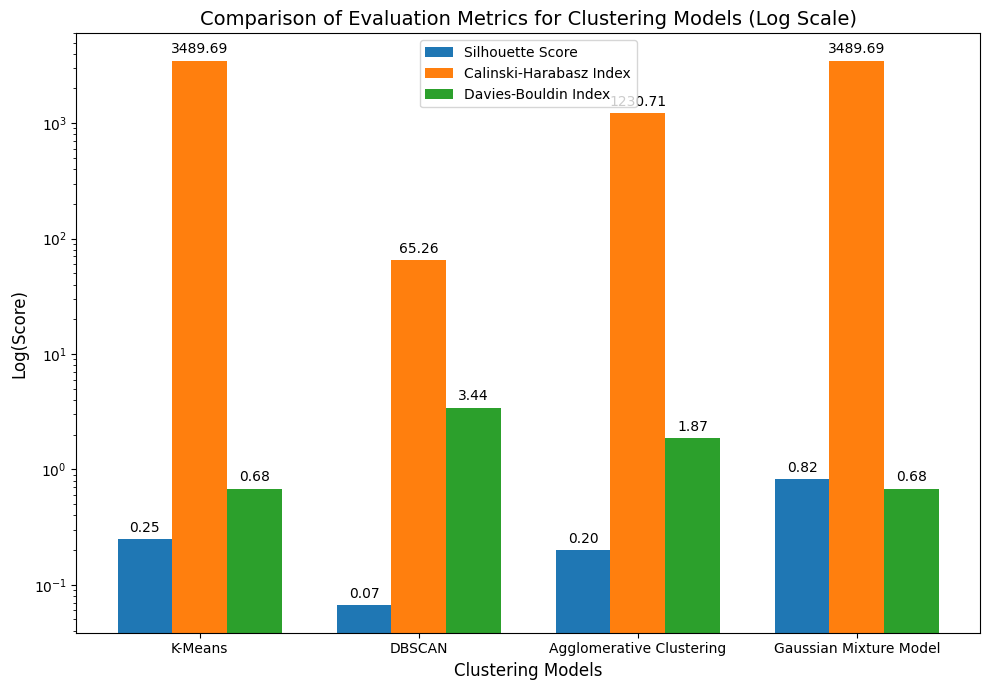

In [61]:
# Các chỉ số đánh giá cho từng mô hình
models = ['K-Means', 'DBSCAN', 'Agglomerative Clustering', 'Gaussian Mixture Model']

# Silhouette, Calinski, Davies-Bouldin cho các mô hình
silhouette_scores = [
    silhouette_avg,               # K-Means
    silhouette_opt,               # DBSCAN
    best_silhouette_score,        # Agglomerative Clustering
    silhouette                    # Gaussian Mixture Model
]

calinski_scores = [
    calinski_harabasz,            # K-Means
    calinski_harabasz_opt,        # DBSCAN
    calinski_scores[silhouette_scores.index(best_silhouette_score)],  # Agglomerative Clustering
    calinski_harabasz             # Gaussian Mixture Model
]

davies_bouldin_scores = [
    davies_bouldin,              # K-Means
    davies_bouldin_opt,          # DBSCAN
    davies_bouldin_scores[silhouette_scores.index(best_silhouette_score)],  # Agglomerative Clustering
    davies_bouldin               # Gaussian Mixture Model
]

# Xử lý các giá trị âm (nếu có) bằng cách lấy giá trị tuyệt đối hoặc thay thế bằng một giá trị nhỏ hơn
def handle_negative(values):
    return [max(0.01, abs(v)) for v in values]  # Đảm bảo giá trị > 0 và không gây lỗi log

# Xử lý dữ liệu
silhouette_scores = handle_negative(silhouette_scores)
calinski_scores = handle_negative(calinski_scores)
davies_bouldin_scores = handle_negative(davies_bouldin_scores)

# Tạo biểu đồ trực quan hóa
x = np.arange(len(models))

# Đặt chiều rộng của các cột trong biểu đồ
width = 0.25

fig, ax = plt.subplots(figsize=(10, 7))

# Vẽ các chỉ số đánh giá cho từng mô hình
rects1 = ax.bar(x - width, silhouette_scores, width, label='Silhouette Score')
rects2 = ax.bar(x, calinski_scores, width, label='Calinski-Harabasz Index')
rects3 = ax.bar(x + width, davies_bouldin_scores, width, label='Davies-Bouldin Index')

# Thêm nhãn, tiêu đề và các tùy chỉnh cho biểu đồ
ax.set_xlabel('Clustering Models', fontsize=12)
ax.set_ylabel('Log(Score)', fontsize=12)
ax.set_title('Comparison of Evaluation Metrics for Clustering Models (Log Scale)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Chuyển đổi trục y sang logarithmic scale
ax.set_yscale('log')

# Tùy chỉnh giá trị trên các cột
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Thêm giá trị vào mỗi cột
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

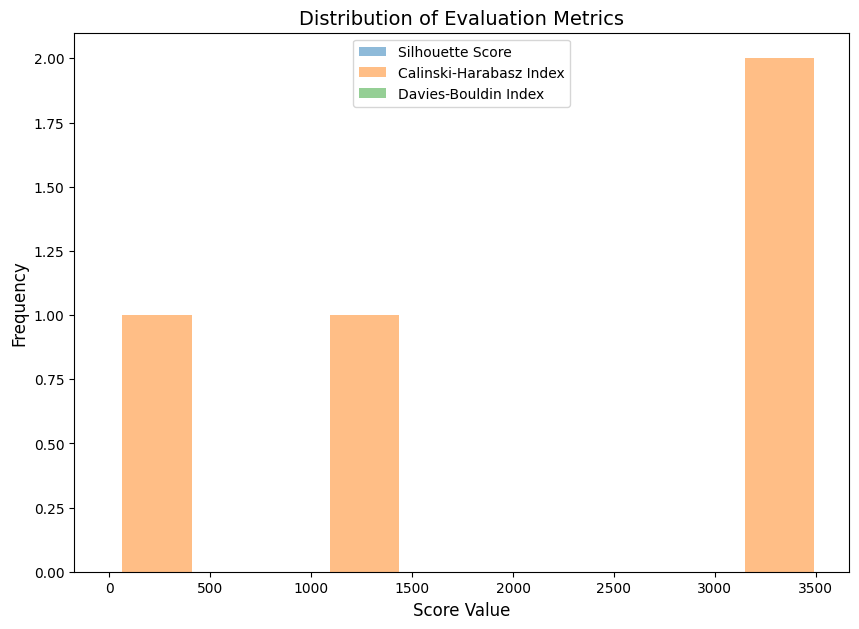

In [62]:
# Biểu đồ phân bố của các chỉ số đánh giá
plt.figure(figsize=(10, 7))
plt.hist(silhouette_scores, bins=10, alpha=0.5, label='Silhouette Score')
plt.hist(calinski_scores, bins=10, alpha=0.5, label='Calinski-Harabasz Index')
plt.hist(davies_bouldin_scores, bins=10, alpha=0.5, label='Davies-Bouldin Index')

plt.xlabel('Score Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Evaluation Metrics', fontsize=14)
plt.legend()
plt.show()

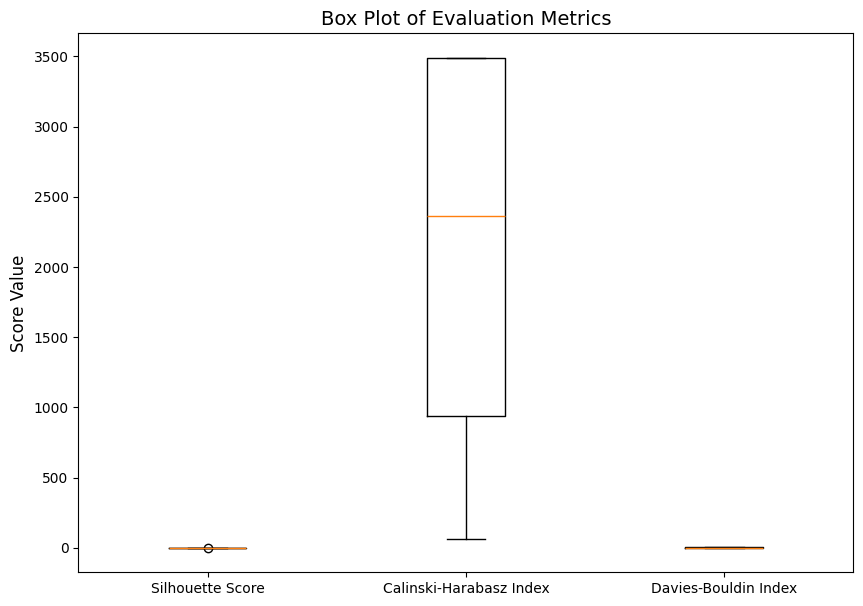

In [63]:
# Biểu đồ hộp cho các chỉ số đánh giá
plt.figure(figsize=(10, 7))
data = [silhouette_scores, calinski_scores, davies_bouldin_scores]
plt.boxplot(data, labels=['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'])

plt.ylabel('Score Value', fontsize=12)
plt.title('Box Plot of Evaluation Metrics', fontsize=14)
plt.show()

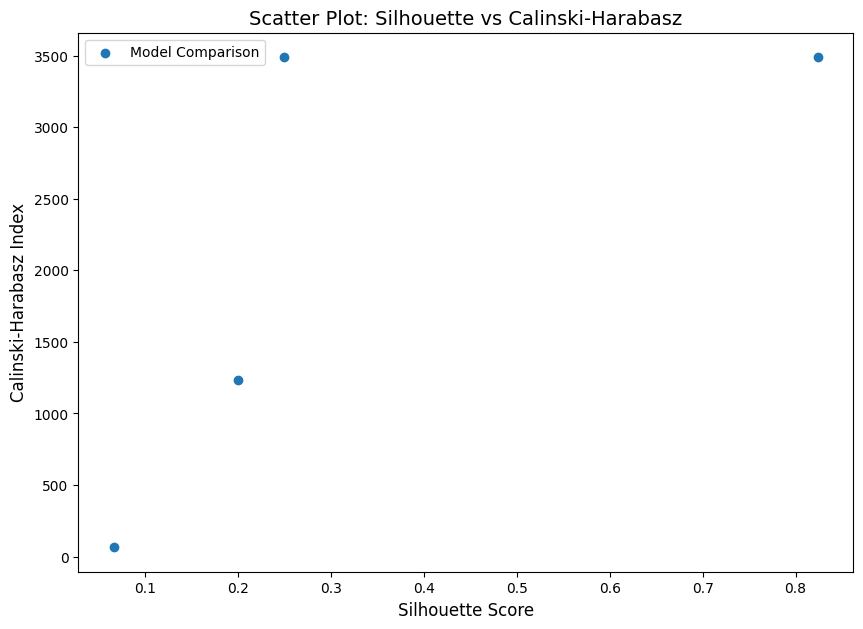

In [64]:
# Biểu đồ tán xạ giữa Silhouette Score và Calinski-Harabasz Index
plt.figure(figsize=(10, 7))
plt.scatter(silhouette_scores, calinski_scores, label='Model Comparison')

plt.xlabel('Silhouette Score', fontsize=12)
plt.ylabel('Calinski-Harabasz Index', fontsize=12)
plt.title('Scatter Plot: Silhouette vs Calinski-Harabasz', fontsize=14)
plt.legend()
plt.show()

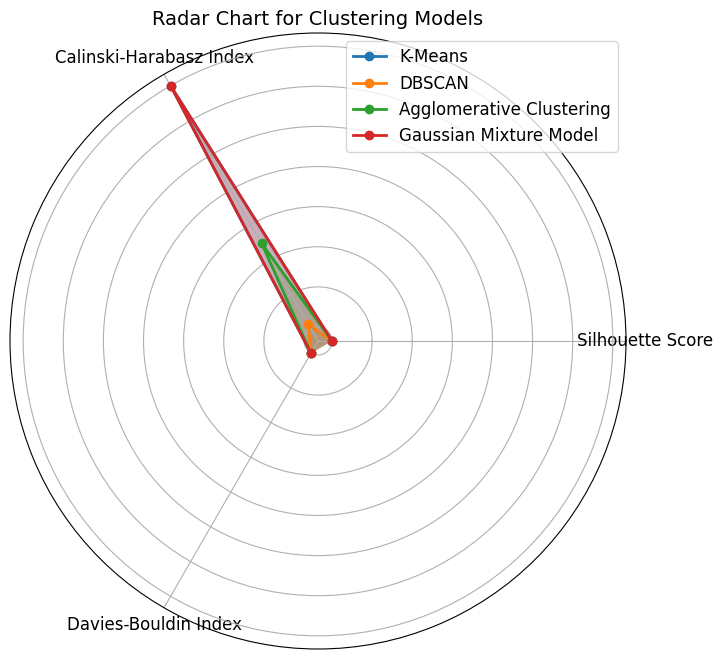

In [65]:
# Biểu đồ radar để so sánh các mô hình gom cụm
import numpy as np
from math import pi

# Các giá trị cho biểu đồ radar
categories = ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index']
values = [
    [silhouette_avg, calinski_harabasz, davies_bouldin],  # K-Means
    [silhouette_opt, calinski_harabasz_opt, davies_bouldin_opt],  # DBSCAN
    [best_silhouette_score, calinski_scores[silhouette_scores.index(best_silhouette_score)], davies_bouldin_scores[silhouette_scores.index(best_silhouette_score)]],  # Agglomerative Clustering
    [silhouette, calinski_harabasz, davies_bouldin]  # Gaussian Mixture Model
]

# Số lượng mô hình
num_models = len(models)

# Vẽ biểu đồ radar
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values = np.array(values)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i in range(num_models):
    ax.plot(angles, values[i], label=models[i], linewidth=2, linestyle='solid', marker='o')
    ax.fill(angles, values[i], alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Radar Chart for Clustering Models', fontsize=14)

plt.show()


In [ ]:
# Biểu đồ 3D để so sánh các mô hình
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Vẽ các mô hình trên biểu đồ 3D
ax.scatter(silhouette_scores, calinski_scores, davies_bouldin_scores, c='r', marker='o')

ax.set_xlabel('Silhouette Score')
ax.set_ylabel('Calinski-Harabasz Index')
ax.set_zlabel('Davies-Bouldin Index')
ax.set_title('3D Plot: Clustering Model Comparison')
plt.show()

# Tiến hành thực thi với tệp dữ liệu giải lập

In [9]:
# Đọc dữ liệu gốc
data = pd.read_csv('X_data.csv')

# Tính các tham số thống kê
mean_std = data.describe().loc[['mean', 'std'], :]

# Hàm tạo dữ liệu giả lập
def generate_synthetic_data(mean_std, size=1000):
    synthetic_data = {}
    for column in mean_std.columns:
        mean = mean_std.loc['mean', column]
        std = mean_std.loc['std', column]
        synthetic_data[column] = np.random.normal(loc=mean, scale=std, size=size)
    return pd.DataFrame(synthetic_data)

# Tạo dữ liệu giả lập
synthetic_data = generate_synthetic_data(mean_std, size=1000)

# Lưu dữ liệu 
synthetic_data.to_csv('synthetic_X_data.csv', index=False)

### 1. Khám phá dữ liệu giải lập

In [26]:
# Tải tệp dữ liệu giải lập
simulated_data = pd.read_csv('synthetic_X_data.csv')

# Thông tin dữ liệu giải lập
print(simulated_data.info)

<bound method DataFrame.info of       Unnamed: 0        Age  Systolic_BP  Diastolic_BP  Cholesterol
0    4185.284744  71.121531    91.386019     78.212995    91.860865
1    6433.106348  47.412663   100.162590     77.494223    85.522147
2     731.837309  55.316982   104.778194     78.295825    95.343406
3    3502.931985  49.511778    98.956589     84.465738   116.714209
4    4292.583332  54.059103   103.096821     83.466964    73.253096
..           ...        ...          ...           ...          ...
995  3760.182471  53.821010    89.177550     84.229112    96.191666
996  -236.771084  57.994344    95.291008     83.915246   110.927173
997  5541.813266  71.814089    95.929424     81.053641   108.436023
998  4791.360890  70.391899   100.345704    104.515767   105.754121
999  -448.783162  68.246902   103.181542     92.350320    88.165271

[1000 rows x 5 columns]>


### 2. Chuẩn hóa dữ liệu giải lập

In [29]:
# Loại bỏ cột không cần thiết(Unnamed: 0)
X_simulated = simulated_data.iloc[:, 1:].values

# Chuẩn hóa dữ liệu
simulated_scaled = StandardScaler()
X_simulated_scaled = simulated_scaled.fit_transform(X_simulated)

### 3. Tiến hành huấn luyện mô hình GMM(Gaussian Mixture Model)

Best Parameters: {'covariance_type': 'tied', 'n_components': 2, 'reg_covar': 0.0001, 'tol': 0.001}
Silhouette Score: 0.8677353059320724
Calinski-Harabasz Index: 716.1756024355445
Davies-Bouldin Index: 0.4499211985784996


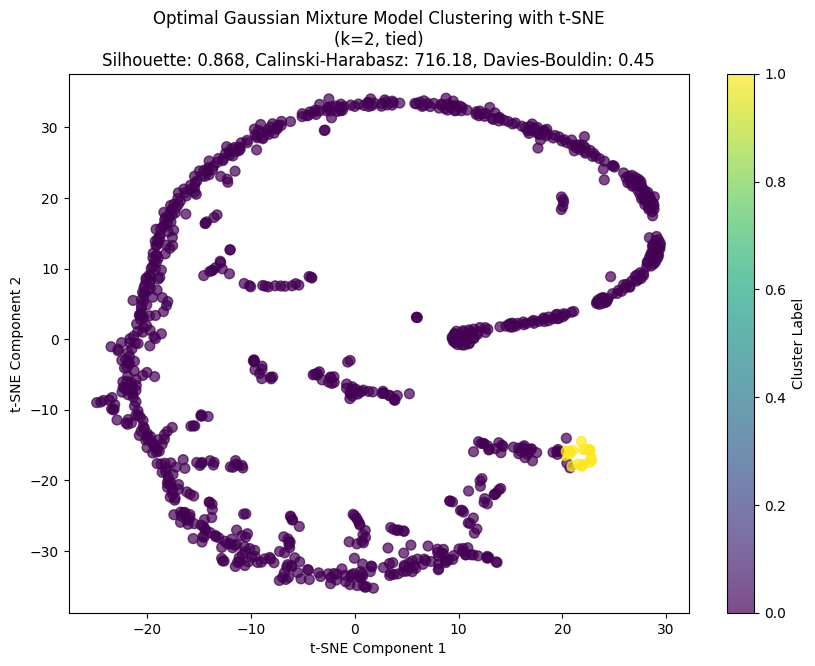

In [33]:

kpca_results = apply_kernel_pca(X_simulated_scaled, gamma_values)

best_gamma, X_kpca = evaluate_kpca_results(kpca_results)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_kpca)
X_filtered = X_kpca[outlier_labels == 1]

gmm, best_params = find_best_gmm(X_filtered, ['full', 'tied', 'diag', 'spherical'], 5)
best_labels = gmm.predict(X_filtered)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

param_grid = {
    'n_components': range(2, 6),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-4]
}

best_gmm = None
best_params = None
best_score = -1

# Perform hyperparameter tuning to find the best model
for params in ParameterGrid(param_grid):
    gmm = GaussianMixture(**params, random_state=42)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            gmm.fit(X_filtered)
        labels = gmm.predict(X_filtered)
        score = silhouette_score(X_filtered, labels)
        if score > best_score:
            best_score = score
            best_gmm = gmm
            best_params = params
    except ValueError as e:
        print(f"Error in hyperparameter tuning: {e}")
        continue

best_labels = best_gmm.predict(X_filtered)
silhouette = silhouette_score(X_filtered, best_labels)
calinski_harabasz = calinski_harabasz_score(X_filtered, best_labels)
davies_bouldin = davies_bouldin_score(X_filtered, best_labels)

print("Best Parameters:", best_params)
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(
    f"Optimal Gaussian Mixture Model Clustering with t-SNE\n"
    f"(k={best_params['n_components']}, {best_params['covariance_type']})\n"
    f"Silhouette: {silhouette:.3f}, Calinski-Harabasz: {calinski_harabasz:.2f}, Davies-Bouldin: {davies_bouldin:.2f}"
)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

### 4. Đánh giá mô hình GMM(Gaussian Mixture Model) từ tệp dữ liệu giải lập

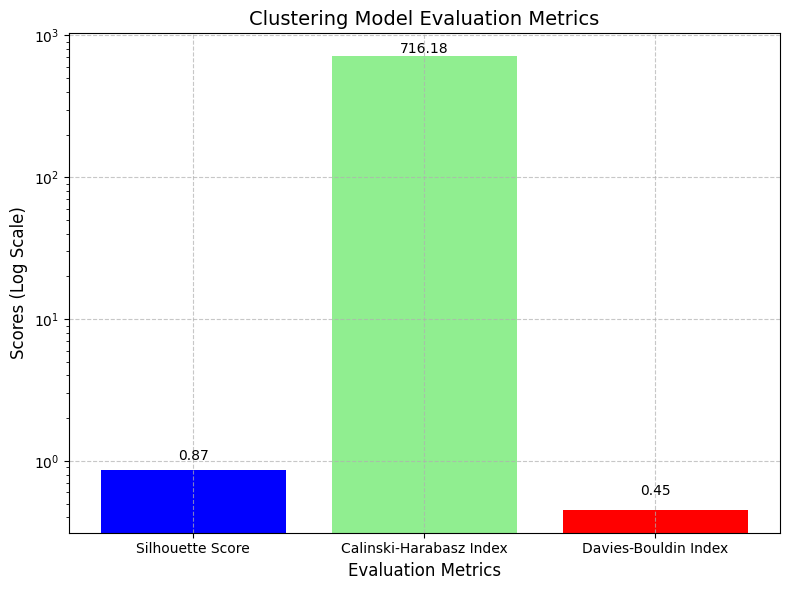

In [34]:
metrics = {
    "Silhouette Score": silhouette,
    "Calinski-Harabasz Index": calinski_harabasz,
    "Davies-Bouldin Index": davies_bouldin
}

fig, ax = plt.subplots(figsize=(8, 6))

labels = list(metrics.keys())
values = list(metrics.values())

ax.bar(labels, values, color=['blue', 'lightgreen', 'red'])
ax.set_yscale('log')  # Set log scale for better visualization

ax.set_title("Clustering Model Evaluation Metrics", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("Evaluation Metrics", fontsize=12)
ax.set_ylabel("Scores (Log Scale)", fontsize=12)

for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 5. Kết luận mô hình GMM(Gaussian Mixture Model)
##### Sau quá trình huấn luyện và đánh giá trên dữ liệu giải lập, mô hình Gaussian Mixture Model (GMM) đã đạt được các kết quả đánh giá rất tích cực với các thông số tối ưu và chỉ số như sau:

##### 1. Các tham số tối ưu:
- Số cụm (n_components): 2
- Loại ma trận hiệp phương sai (covariance_type): tied
- Giá trị điều chuẩn (reg_covar): 0.0001
- Ngưỡng hội tụ (tol): 0.001

##### 2. Chỉ số đánh giá mô hình:
- Silhouette Score: 0.8677
  (Điểm Silhouette cho thấy mô hình phân cụm đạt mức độ phân biệt rất cao giữa các cụm, với giá trị gần 1, cho thấy các cụm được phân tách rõ ràng.)
- Calinski-Harabasz Index: 716.18
  (Chỉ số này cao, biểu thị rằng các cụm có tính liên kết tốt trong khi vẫn phân tách rõ ràng với nhau.)
- Davies-Bouldin Index: 0.450
  (Giá trị này thấp, cho thấy các cụm có sự tách biệt tốt và ít bị chồng lấn.)

##### 3. Kết quả trực quan hóa:
- Phân cụm được trực quan hóa bằng t-SNE, cho thấy các cụm dữ liệu rõ ràng và hợp lý trên không gian giảm chiều.
- Biểu đồ so sánh các chỉ số đánh giá đã minh họa sự vượt trội của mô hình GMM với cấu hình tối ưu.

##### 4. Nhận định và ý nghĩa:
- Tính hiệu quả của mô hình: GMM với cấu hình tối ưu đã chứng minh khả năng phân cụm hiệu quả trên dữ liệu giải lập, đặc biệt là trong việc xử lý dữ liệu phức tạp với sự khác biệt nhỏ giữa các cụm.
- Ứng dụng thực tế: Kết quả này cho thấy GMM có thể được áp dụng vào các bài toán tương tự trong thực tế, như phân cụm bệnh nhân hoặc phân tích tập khách hàng, nơi mà sự tách biệt giữa các cụm là rất quan trọng.
- Hạn chế: Mô hình yêu cầu điều chỉnh tham số cẩn thận và có thể nhạy cảm với các outlier. Tuy nhiên, việc sử dụng Isolation Forest trước khi huấn luyện đã giảm thiểu rủi ro này.

##### 5. Hướng phát triển tiếp theo:
- Mở rộng thử nghiệm với các dữ liệu thực tế lớn hơn.
- Kết hợp với các kỹ thuật tối ưu hóa khác, như Ensemble Clustering, để tăng cường độ chính xác và khả năng áp dụng rộng rãi.